In [1]:
import pandas as pd 
import numpy as np
import random
import os 
import re
import time
import math
import argparse
import pymysql
import json
import torch
import pickle
import time
import matplotlib.pyplot as plt
from torchmetrics import R2Score
from torch import nn
from fastprogress.fastprogress import master_bar, progress_bar
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
from transformers import BertConfig, BertTokenizer, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup
from sklearn.metrics import precision_score , recall_score , confusion_matrix, f1_score, classification_report


2023-01-25 16:51:34.734869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 16:51:34.930647: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-25 16:51:34.974166: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-25 16:51:35.574098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
data_path = "/home/lamda_00/Depression_paper/data/"
model_path = "/home/lamda_00/Depression_paper/model/"
ckpt_path = "/home/lamda_00/Depression_paper/ckpt/"
config_path = "/home/lamda_00/Depression_paper/config/"
log_path = "/home/lamda_00/Depression_paper/log/"
config_file = "bert-base.json"

In [3]:
label = dict()

label[0] = '우울'
label[1] = '무기력'
label[2] = '급격한 체중(식욕)변화'
label[3] = '수면장애'
label[4] = '정서불안'
label[5] = '피로'
label[6] = '과도한 죄책감 및 무가치함'
label[7] = '인지기능저하'
label[8] = '자살충동'
label[9] = '일상'
label

{0: '우울',
 1: '무기력',
 2: '급격한 체중(식욕)변화',
 3: '수면장애',
 4: '정서불안',
 5: '피로',
 6: '과도한 죄책감 및 무가치함',
 7: '인지기능저하',
 8: '자살충동',
 9: '일상'}

In [4]:
with open(os.path.join(data_path, 'conv_translated.pickle'), 'rb') as f:
    conv = pickle.load(f)
    
conv = conv[['speaker_idx', 'translated']]
conv.columns = ['speaker', 'text']
conv.head()

,speaker,text
0,User,hey
1,Chatbot,"Hello, nice to meet you"
2,User,what is your name ?
3,Chatbot,I am a psychological counseling chatbot
4,User,Ah-huh


In [5]:
conv.loc[6].text = 'I am so depressed today'
conv.loc[12]. text = 'I can not sleep because I have too much work to do'

In [6]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))
    
training_config.pad = 'max_length'
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [7]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    # def clear_text(self)  => 전처리 코드를 여기에 넣을 경우 상당히 느려짐
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [8]:
class BertRegressor(nn.Module):
    def __init__(self, config, model):
        super(BertRegressor, self).__init__()
        self.model = model
        self.linear = nn.Linear(config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.last_hidden_state[:, 0, :]
        x = self.linear(logits)
        x = self.relu(x)
        score = self.out(x)
        return score 

In [9]:
class BertProcessor():
    def __init__(self, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = 32
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification

        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def convert_sentence(self, sent_list):   # 사용자 입력 문장 1개 -> 입력 형태 변환
        context2 = None 
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(sent_list, context2)], max_length=self.max_len, padding=self.pad, truncation=self.truncation
        )
        
        features = []
        inputs = {k: batch_encoding[k][0] for k in batch_encoding}
        inputs['label'] = 0 
        features.append(inputs)

        input_id = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        input_am = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        input_tts = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        input_lb = torch.tensor([f['label'] for f in features], dtype=torch.long)
        dataset = TensorDataset(input_id, input_am, input_tts, input_lb)
        return dataset
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [10]:
class BertRegTester():
    def __init__(self, training_config, model):
        self.training_config = training_config
        self.model = model

    def get_label(self, test_dataloader, test_type):
        '''
        test_type: 0  -> Test dataset 
        test_type: 1  -> Test sentence
        '''
        preds = []
        labels = []

        for batch in test_dataloader:
            self.model.eval()   # self 안 붙이면 이상한 Output (BaseModelOutputWithPoolingAndCrossAttentions) 출력 
            batch = tuple(t.to(training_config.device) for t in batch)   # args.device: cuda 
            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                }
                outputs = self.model(**inputs)
                if test_type == 0:
                    preds.extend(outputs.squeeze().detach().cpu().numpy())
                elif test_type == 1:
                    preds.extend(outputs[0].detach().cpu().numpy())            
            label = batch[3].detach().cpu().numpy()
            labels.extend(label)
        return preds, labels 

In [11]:
class BertClsTester():
    def __init__(self, training_config, model):
        self.training_config = training_config
        self.model = model

    def get_label(self, test_dataloader, test_type):
        '''
        test_type: 0  -> Test dataset 
        test_type: 1  -> Test sentence
        '''
        preds = []
        labels = []

        for batch in test_dataloader:
            self.model.eval()
            batch = tuple(t.to(self.training_config.device) for t in batch)   # args.device: cuda 
            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                    "labels": batch[3]
                }
                outputs = self.model(**inputs)
                test_loss, logits = outputs[:2] 
                pred = logits.detach().cpu().numpy()
                if test_type == 0:
                    preds.extend(np.argmax(pred, axis=1))
                elif test_type == 1:
                    preds.append(np.argmax(pred))  
                            
            label = inputs["labels"].detach().cpu().numpy()
            labels.extend(label)
  
        return preds, labels 
    
    def get_f1_score(self, test_dataloader):
        y_pred, y_true = self.get_label(test_dataloader)
        return round(f1_score(y_true, y_pred, average='micro'), 3) 
     
    def get_cl_report(self, test_dataloader):
        y_pred, y_true = self.get_label(test_dataloader, 0)
        cr = classification_report(y_true, y_pred).split('\n')
        clr_df = []

        for idx, line in enumerate(cr):
            clr_df.append([])
            if line == '':
                continue

            word_list = line.strip().split(' ')

            for word in word_list:
                if word != '':
                    clr_df[idx].append(word)

        clr_df[-2][0] = ' '.join([clr_df[-2][0], clr_df[-2][1]])
        clr_df[-3][0] = ' '.join([clr_df[-3][0], clr_df[-3][1]])
        clr_df[-4].insert(1, ' ')
        clr_df[-4].insert(2, ' ')
        clr_df[0].insert(0, 'index')

        clr_df[-2].pop(1)
        clr_df[-3].pop(1)
        clr_df.pop(1)
        clr_df.pop(-1)
        clr_df.pop(-4)
        clr_df = pd.DataFrame(clr_df[1:], columns=clr_df[0])
        clr_df.index = clr_df['index']

        del clr_df['index']
        return clr_df

#### Regression Model

In [382]:
X_test = pd.read_csv(os.path.join(data_path, 'bws_bin_samp_test.csv'))
X_test.head(3)

,text,text_kor,label
0,i've tried to ignore my feelings but i really ...,나는 내 감정을 무시하려고 노력했지만 정말 우울하다,0
1,to about ish and my mothers just been getting ...,나는 그녀에게 우울증이 있다고 말했고 그녀는 내가 더 일찍 일어나야 한다고 말했고 ...,0
2,at the apex we feel something at the trough we...,정점에서 우리는 무언가를 느낀다 우리는 우울하게 느끼는 무언가를 느낀다,0


In [600]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-base'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-base', 'bert_config.json'))
model = BertModel.from_pretrained(os.path.join(model_path, 'bert-base'), config=config)

Some weights of the model checkpoint at /home/lamda_00/Depression_paper/model/bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [601]:
test_processor = BertProcessor(training_config, tokenizer)

In [602]:
test_file = BertDataset(X_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [603]:
config.max_position_embeddings = 32

In [604]:
model_reg = BertRegressor(config, model)

In [605]:
model_name = os.path.join(model_path, 'bws', 'bert_bin_samp_base.pt')
# model_name = os.path.join(model_path, 'bws', 'bert_bws_medium.pt') 

In [606]:
model_reg.load_state_dict(torch.load(model_name))
model_reg.to(training_config.device)

BertRegressor(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [607]:
bert_tester = BertRegTester(training_config, model_reg)

In [608]:
start = time.time()
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)
print(f'소요 시간: {time.time() - start}')

소요 시간: 0.11694741249084473


In [609]:
X_test

,text,text_kor,label
0,i've tried to ignore my feelings but i really ...,나는 내 감정을 무시하려고 노력했지만 정말 우울하다,0
1,to about ish and my mothers just been getting ...,나는 그녀에게 우울증이 있다고 말했고 그녀는 내가 더 일찍 일어나야 한다고 말했고 ...,0
2,at the apex we feel something at the trough we...,정점에서 우리는 무언가를 느낀다 우리는 우울하게 느끼는 무언가를 느낀다,0
3,i don't think i am depressed or suicidal but v...,나는 내가 우울하거나 자살했다고 생각하지 않지만 매우 매우 지루하고 혼자라고 생각한다,0
4,now that my ankle is healed though i feel depr...,다시 우울해지긴 했지만 발목이 다 나았으니,0
...,...,...,...
315,upon receiving the news each time i've been un...,매번 그 소식을 듣자마자 나는 울거나 슬퍼할 수 없었다,0
316,Why are you doing this when you're not even dr...,술도 안 취했는데 왜 이러는 거야?,1
317,whenever i feel lonely i go here only to reali...,내가 외로울 때마다 나는 내가 아니라는 것을 깨달았을 뿐이다,0
318,"During the training, I was able to get my grad...","훈련 기간 동안, 나는 5등까지 성적을 올릴 수 있었다",1


In [610]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [611]:
criterion = RMSELoss

In [612]:
loss = criterion(torch.Tensor(y_pred), torch.Tensor((y_true)))
loss

tensor(0.0568)

In [613]:
r2score = R2Score()
r2score(torch.Tensor(y_pred), torch.Tensor(y_true))

tensor(0.9811)

In [614]:
X_test.text[2]

'at the apex we feel something at the trough we feel depressed'

In [615]:
y_pred[:10], y_true[:10]

([-0.004119586,
  -0.0010512322,
  -0.004600115,
  -0.004085593,
  -0.004511263,
  1.0184597,
  1.0187069,
  -0.0044231527,
  -0.004274998,
  -0.004575271],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [616]:
test_sent = "I am so depressed today" # X_test.text[0]
test_data = test_processor.convert_sentence(test_sent)
test_sampler = test_processor.shuffle_data(test_data, 'test')
test_loader = test_processor.load_data(test_data, test_sampler)

In [617]:
start = time.time()
y_pred, y_true = bert_tester.get_label(test_loader, 1)
print(f'소요 시간: {time.time() - start}')

소요 시간: 0.013761758804321289


In [618]:
y_pred

[-0.0036349222]

In [619]:
user_conv = conv[conv.speaker=='User']
user_conv['label'] = 9999

/tmp/ipykernel_2132/863694454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_conv['label'] = 9999


In [620]:
conv_file = BertDataset(user_conv)
conv_dataset = test_processor.convert_data(conv_file)
conv_sampler = test_processor.shuffle_data(conv_dataset, 'test')
conv_dataloader = test_processor.load_data(conv_dataset, conv_sampler)

In [621]:
y_pred, y_true = bert_tester.get_label(conv_dataloader, 0)

In [622]:
user_conv['label'] = y_pred
user_conv

/tmp/ipykernel_2132/3963311452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_conv['label'] = y_pred


,speaker,text,label
0,User,hey,1.024590
1,User,what is your name ?,1.021050
2,User,Ah-huh,1.019895
3,User,I am so depressed today,-0.003669
4,User,I just feel so lethargic these days,0.998461
5,User,I think he's psychologically exhausted,1.020808
6,User,I can not sleep because I have too much work t...,1.014418
7,User,I should I'll go for a walk from time to time,1.023432
8,User,Thanks for listening,1.022637


In [ ]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-mini'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-mini', 'bert_config.json'))
model = BertModel.from_pretrained(os.path.join(model_path, 'bert-mini'), config=config)

In [ ]:
conv = ['hey', 'I feel very depressed', 'I feed depressed', 'I feel sad', 'I cry everyday', 'I went to school', 'I want to die']
dep_test = pd.DataFrame(conv, columns=['text'])
dep_test['label'] = 9999

In [ ]:
test_file = BertDataset(dep_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [ ]:
model_reg = BertRegressor(config, model)
# model_reg2 = BertRegressor(config, model)

In [ ]:
model_name = os.path.join(model_path, 'bert_bws_best.pt')

In [ ]:
model_reg.load_state_dict(torch.load(model_name))
model_reg.to(training_config.device)

In [ ]:
bert_tester = BertTester(training_config, model_reg)

In [ ]:
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)

In [ ]:
dep_test['label'] = [pred for pred in y_pred]
dep_test

#### Classification 

In [12]:
X_test = pd.read_csv(os.path.join(data_path, 'dsm_samp2_test.csv'))
X_test.head(3)

,id,text,label
0,4fws4y,"anyways, the doctor says be careful because yo...",3
1,t3_23p0b1,"i also have [aka *amerge*] for migraines, but ...",3
2,26twx8,all in all i feel worthless pretty much the on...,8


In [13]:
X_test.label.unique()

array([3, 8, 0, 6, 1, 2, 7, 5, 4])

In [14]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-medium'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-medium', 'bert_config.json'), num_labels=9, output_hidden_states=True)
model = BertForSequenceClassification.from_pretrained(os.path.join(model_path, 'bert-medium'), config=config)

Some weights of the model checkpoint at /home/lamda_00/Depression_paper/model/bert-medium were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequence

In [15]:
config.max_position_embeddings = 32

In [16]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

training_config.pad = 'max_length'
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [18]:
test_processor = BertProcessor(training_config, tokenizer)

In [19]:
test_file = BertDataset(X_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [20]:
# model_name = os.path.join(model_path, 'label_9', 'bert_tiny', 'bert_dsm_4.pt')
# model_name = os.path.join(model_path, 'label_9', 'bert_mini', 'bert_dsm_3.pt')
# model_name = os.path.join(model_path, 'label_9', 'bert_small', 'bert_dsm_2.pt')
model_name = os.path.join(model_path, 'label_9', 'bert_medium', 'bert_dsm_1.pt')
# model_name = os.path.join(model_path, 'label_9', 'bert_base', 'bert_dsm_1.pt')

In [21]:
model.load_state_dict(torch.load(model_name))
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [26]:
dsm_samp = X_test.copy()
dsm_samp = dsm_samp.sample(10)
dsm_samp.reset_index(inplace=True, drop=True)

In [43]:
dsm_emb = []

for idx in range(len(dsm_samp)):
    encoded = tokenizer.encode_plus(
        text=dsm_samp.text[idx],  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 64,  # maximum length of a sentence
        pad_to_max_length=True,  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
    input_ids = torch.tensor(encoded['input_ids']).to(training_config.device)
    attn_mask = torch.tensor(encoded['attention_mask']).to(training_config.device)
    token_type_ids = torch.tensor(encoded['token_type_ids']).to(training_config.device)
    
    outputs = model(input_ids, attn_mask, token_type_ids)
    print(outputs[1])
   # hidden_states = outputs[2]
   # embedding_output = hidden_states[0]
   # dsm_emb.append(list(embedding_output[0][0].detach().cpu().numpy()))

/tmp/ipykernel_13550/863001631.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded['input_ids']).to(training_config.device)
/tmp/ipykernel_13550/863001631.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attn_mask = torch.tensor(encoded['attention_mask']).to(training_config.device)
/tmp/ipykernel_13550/863001631.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(encoded['token_type_ids']).to(training_config.device)


(tensor([[[-0.3488, -0.0769,  0.2981,  ...,  0.1186, -0.8865, -0.2565],
         [-0.6444,  0.4148, -1.0298,  ..., -0.2488, -0.1934, -0.2653],
         [-1.0660, -1.3672,  1.2306,  ...,  0.3471,  1.2565, -0.5600],
         ...,
         [ 1.2903,  1.2293, -0.6751,  ..., -0.7249,  0.5980,  0.8214],
         [ 1.1868,  1.0863, -0.7637,  ..., -0.6505,  0.4221,  0.9262],
         [ 1.0921,  1.3333, -0.9059,  ..., -0.5595,  0.3507,  1.0133]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), tensor([[[ 0.0273,  0.0215, -0.0125,  ..., -0.0173, -0.7817, -0.4272],
         [-0.8866, -0.6256, -0.7915,  ...,  0.9680,  0.4882,  0.2822],
         [-0.8618, -2.0142,  1.3832,  ...,  0.8132,  0.8005, -0.4759],
         ...,
         [ 1.7118,  1.1357, -0.5227,  ..., -1.0272,  0.3860,  0.3627],
         [ 1.5217,  0.9647, -0.5361,  ..., -0.9806,  0.1686,  0.4496],
         [ 1.3314,  1.0795, -0.7452,  ..., -0.9855,  0.1476,  0.6717]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackwa

In [919]:
bert_tester = BertClsTester(training_config, model)

In [920]:
start = time.time()
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)
print(f'소요 시간: {time.time() - start}')

소요 시간: 5.086172103881836


In [921]:
from torchmetrics.classification import F1Score
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassSpecificity

f1 = F1Score(task="multiclass", num_classes=len(X_test.label.unique()))
precision = MulticlassPrecision(num_classes=len(X_test.label.unique()))
recall = MulticlassRecall(num_classes=len(X_test.label.unique()))
specificity = MulticlassSpecificity(num_classes=len(X_test.label.unique()))

In [922]:
print(f'precision: {precision(torch.Tensor(y_pred), torch.Tensor(y_true))}')
print(f'recall: {recall(torch.Tensor(y_pred), torch.Tensor(y_true))}')
print(f'specificity: {specificity(torch.Tensor(y_pred), torch.Tensor(y_true))}')
print(f'f1-score: {f1(torch.Tensor(y_pred), torch.Tensor(y_true))}')

precision: 0.9923352003097534
recall: 0.9836284518241882
specificity: 0.9985994100570679
f1-score: 0.991443932056427


In [881]:
test_sent = "I can't sleep because I have too much work to do" # X_test.text[0]
test_data = test_processor.convert_sentence(test_sent)
test_sampler = test_processor.shuffle_data(test_data, 'test')
test_loader = test_processor.load_data(test_data, test_sampler)

In [829]:
start = time.time()
y_pred2, y_true2 = bert_tester.get_label(test_loader, 1)
print(f'소요 시간: {time.time() - start}')

소요 시간: 0.012841463088989258


In [ ]:
conv_file = BertDataset(user_conv)
conv_dataset = test_processor.convert_data(conv_file)
conv_sampler = test_processor.shuffle_data(conv_dataset, 'test')
conv_dataloader = test_processor.load_data(conv_dataset, conv_sampler)

In [ ]:
y_pred, y_true = bert_tester.get_label(conv_dataloader, 0)

In [923]:
from sklearn.metrics import precision_score , recall_score , confusion_matrix, f1_score, classification_report

confusion_mt = pd.DataFrame(confusion_matrix(y_true, y_pred))
confusion_mt

,0,1,2,3,4,5,6,7,8
0,7979,3,1,2,1,0,5,0,9
1,4,408,0,1,0,0,2,1,0
2,3,3,1017,0,0,0,1,0,2
3,12,0,1,1433,0,0,0,0,0
4,3,0,1,2,136,0,0,0,1
5,2,0,2,3,0,339,1,0,1
6,48,0,1,5,0,0,3942,0,4
7,2,0,0,1,0,0,1,486,0
8,31,1,1,2,0,0,4,2,3959


In [924]:
len(y_pred)

19869

In [925]:
from sklearn.preprocessing import label_binarize 

y_true = label_binarize(y_true, classes=list(range(len(label))))
y_pred = label_binarize(y_pred, classes=list(range(len(label))))

In [926]:
from sklearn.metrics import roc_curve, auc

n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict() 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

/home/ubuntu/anaconda3/envs/lamda_base/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


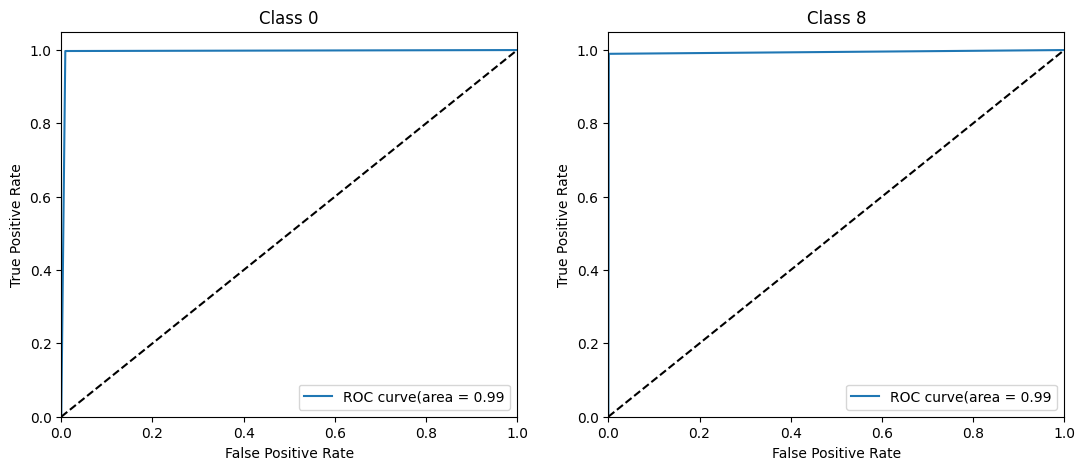

In [929]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20, 5))
val = 0

for idx, i in enumerate(range(n_classes)):
    if idx == 0 or idx == 8: 
        plt.subplot(131+val) 
        plt.plot(fpr[i], tpr[i], label = f'ROC curve(area = {round(roc_auc[i], 2)}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate') 
        plt.ylabel('True Positive Rate')
        plt.title(f'Class {idx}')
        plt.legend(loc='lower right')
        val += 1
plt.show()